# A short & practical introduction to Tensor Flow!

Part 5

Example of a single-layer one-directional long short-term memory network (LSTM) trained with
[connectionist temporal classification](http://www.cs.toronto.edu/~graves/icml_2006.pdf) to predict character sequences from nFeatures x nFrames
arrays of Mel-Frequency Cepstral Coefficients.  This is test code to run on the
8-item data set in the "sample_data" directory, for those without access to TIMIT.

Author: [Jon Rein](https://github.com/jonrein/tensorflow_CTC_example) 

Adapted by: Pablo M. Olmos (olmos@tsc.uc3m.es)

Date: March 2017






In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.ops import ctc_ops as ctc
import numpy as np
from utils import load_batched_data

In [5]:
# Lets check what version of tensorflow we have installed. The provided scripts should run with tf 1.0 and above

print(tf.__version__)

1.3.0


In [6]:
batchSize = 4 # Batch of sequences

## Change according to the folder where you saved the dataset provided
INPUT_PATH = '../../DataSets/MCC_sample_data_phoneme_recog/mfcc' #directory of MFCC nFeatures x nFrames 2-D array .npy files
TARGET_PATH = '../../DataSets/MCC_sample_data_phoneme_recog/char_y/' #directory of nCharacters 1-D array .npy files

####Load data
print('Loading data')
batchedData, maxTimeSteps, totalN = load_batched_data(INPUT_PATH, TARGET_PATH, batchSize) 

Loading data


In [7]:
####Learning Parameters
learningRate = 0.001
momentum = 0.9
nEpochs = 200

####Network Parameters
nFeatures = 26 #12 MFCC coefficients + energy, and derivatives
nHidden = 128
nClasses = 28#27 characters, plus the "blank" for CTC

## Creating the computation graph

We will create a LSTM layer with 128 memory cells. On top of this, we use a fully connected soft-max layer.

We use [CTC classification](http://www.cs.toronto.edu/~graves/icml_2006.pdf) to compute the loss function that we can optimize by gradient descend. This function is already provided in the TF [contributions library](        https://www.tensorflow.org/versions/r0.10/api_docs/python/nn/conectionist_temporal_classification__ctc_)

### LSTMs 

Recall the fundamental model


<img src="files/figLSTM.png">

Also, the un-regularized cost function is

\begin{align}
J(\boldsymbol{\theta})=\frac{1}{N}\sum_{n=1}^N\sum_{t=1}^{T_n}d(\boldsymbol{y}_t^{(n)},\text{softmax}(\boldsymbol{W}_h \boldsymbol{h}_t^{(n)}+\mathbf{b}))
\end{align}
where $d(\cdot,\cdot)$ is the cross-entropy loss function.




In [8]:
####Define graph
print('Defining graph')
graph = tf.Graph()
with graph.as_default():
 

    #### We start by encoding the forward LSTM with nHidden cells
    
    #i(t) parameters
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([nFeatures, nHidden], -0.1, 0.1))   ##W^ix
    im = tf.Variable(tf.truncated_normal([nHidden, nHidden], -0.1, 0.1)) ## W^ih
    ib = tf.Variable(tf.zeros([1, nHidden])) ##b_i
    
    #f(t) parameters
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([nFeatures, nHidden], -0.1, 0.1)) ##W^fx
    fm = tf.Variable(tf.truncated_normal([nHidden, nHidden], -0.1, 0.1)) ##W^fh
    fb = tf.Variable(tf.zeros([1, nHidden])) ##b_f
    
    #g(t) parameters
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([nFeatures, nHidden], -0.1, 0.1)) ##W^gx
    cm = tf.Variable(tf.truncated_normal([nHidden, nHidden], -0.1, 0.1)) ##W^gh
    cb = tf.Variable(tf.zeros([1, nHidden]))  ##b_g
    
    #o(t) parameters
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([nFeatures, nHidden], -0.1, 0.1))  ##W^ox
    om = tf.Variable(tf.truncated_normal([nHidden, nHidden], -0.1, 0.1))  ##W^oh
    ob = tf.Variable(tf.zeros([1, nHidden])) ##b_o
    
    # Variable saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batchSize, nHidden]), trainable=False) #h(t)
    saved_state = tf.Variable(tf.zeros([batchSize, nHidden]), trainable=False) #s(t)
    ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  #### 
    
    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb       
        state = forget_gate * state + input_gate * tf.tanh(update)    #tf.tanh(update) is g(t)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state      #h(t) is output_gate * tf.tanh(state) 
    ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  #### 
    
    # Classifier weights and biases (over h(t) and b_h(t) to labels)
    w = tf.Variable(tf.truncated_normal([nHidden, nClasses], -0.1, 0.1))
    b = tf.Variable(tf.zeros([nClasses]))    
   

    ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####  #### 
    
    # Now we define the placeholders for the input data
        
    train_data = list()
    for _ in range(maxTimeSteps):
        train_data.append(tf.placeholder(tf.float32, shape=[batchSize,nFeatures]))

    targetIxs = tf.placeholder(tf.int64)
    targetVals = tf.placeholder(tf.int32)
    targetShape = tf.placeholder(tf.int64)
    targetY = tf.SparseTensor(targetIxs, targetVals, targetShape)
    seqLengths = tf.placeholder(tf.int32, shape=(batchSize))    
        
    # Given the input, we indicate how to compute the hidden states  
        
    # Unrolled forward LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_data:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    
    # With this, we make sure that the loss is not computed until all states are first evaluate
    with tf.control_dependencies([saved_output.assign(output),saved_state.assign(state)]):
        #Classifier.
        logits = tf.reshape(tf.matmul(tf.concat(axis=0,values=outputs),w)+b,[-1,batchSize,nClasses]) 
        loss = tf.reduce_mean(ctc.ctc_loss(inputs=logits, labels=targetY,  sequence_length=seqLengths))
    
    ####Optimizing
    optimizer = tf.train.MomentumOptimizer(learningRate, momentum).minimize(loss)

    ####Evaluating
    # We use greedy decoding to estimate label sequences for training data
    logitsMaxTest = tf.slice(tf.argmax(logits, 2), [0, 0], [seqLengths[0], 1])
    predictions = tf.to_int32(ctc.ctc_beam_search_decoder(logits, seqLengths)[0][0])
    errorRate = tf.reduce_sum(tf.edit_distance(predictions, targetY, normalize=False)) / tf.to_float(tf.size(targetY.values))

Defining graph


In [9]:
####Run session
with tf.Session(graph=graph) as session:
    print('Initializing')
    tf.global_variables_initializer().run()
    
    for epoch in range(nEpochs):
        print('Epoch', epoch+1, '...')
        batchErrors = np.zeros(len(batchedData))
        batchRandIxs = np.random.permutation(len(batchedData)) #randomize batch order
        for batch, batchOrigI in enumerate(batchRandIxs):
            batchInputs, batchTargetSparse, batchSeqLengths = batchedData[batchOrigI]
            batchTargetIxs, batchTargetVals, batchTargetShape = batchTargetSparse
            feedDict = {targetIxs: batchTargetIxs, targetVals: batchTargetVals,
                        targetShape: batchTargetShape, seqLengths: batchSeqLengths}
            for i in range(maxTimeSteps):
                feedDict[train_data[i]] = batchInputs[i,:,:]
                
            _, l, er, lmt, logits_out = session.run([optimizer, loss, errorRate, logitsMaxTest,logits], feed_dict=feedDict)
            print(np.unique(lmt)) #print unique argmax values of first sample in batch; should be blank for a while, then spit out target values
            if (batch % 1) == 0:
                print('Minibatch', batch, '/', batchOrigI, 'loss:', l)
                print('Minibatch', batch, '/', batchOrigI, 'error rate:', er)
            batchErrors[batch] = er*len(batchSeqLengths)
        epochErrorRate = batchErrors.sum() / totalN
        print('Epoch', epoch+1, 'error rate:', epochErrorRate)
        
        

Initializing
Epoch 1 ...
[ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 20 21 23 24 25 26 27]
Minibatch 0 / 0 loss: 908.24
Minibatch 0 / 0 error rate: 1.72816
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 21 22 23 24 25 26 27]
Minibatch 1 / 1 loss: 868.786
Minibatch 1 / 1 error rate: 1.65306
Epoch 1 error rate: 1.69060832262
Epoch 2 ...
[ 0  2  3  5 10 12 17 18 21 24 26 27]
Minibatch 0 / 1 loss: 807.372
Minibatch 0 / 1 error rate: 1.36395
[27]
Minibatch 1 / 0 loss: 701.823
Minibatch 1 / 0 error rate: 0.919094
Epoch 2 error rate: 1.14151972532
Epoch 3 ...
[27]
Minibatch 0 / 1 loss: 529.089
Minibatch 0 / 1 error rate: 0.659864
[27]
Minibatch 1 / 0 loss: 379.771
Minibatch 1 / 0 error rate: 0.776699
Epoch 3 error rate: 0.71828147769
Epoch 4 ...
[27]
Minibatch 0 / 0 loss: 285.586
Minibatch 0 / 0 error rate: 0.928803
[27]
Minibatch 1 / 1 loss: 235.717
Minibatch 1 / 1 error rate: 0.979592
Epoch 4 error rate: 0.954197227955
Epoch 5 ...
[27]
Minibatch 0 / 0 loss: 249.514
Minibatch

In [10]:
logits_out.shape

(423, 4, 28)

In [11]:
import matplotlib.pyplot as plt

In [12]:
# Lets visualize the prediction for the first training sequence
np.argmax(logits_out[:,0,:],axis=1)

array([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 10, 26, 26,  9,
       12, 19, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0, 26, 26, 22, 25,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  5, 12, 12, 12, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27,  0,  8, 26, 26, 17, 26, 26, 27, 27, 27, 14, 12, 27,
       27, 27, 27, 27, 27, 27, 27,  2,  0,  0, 12, 21, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  4,  0,
        0, 15,  4, 27, 27, 27, 27, 27, 14, 27, 27, 27, 27, 27, 27, 27, 27,
       12, 19, 15, 12,  0, 15, 27, 27, 27, 27, 27, 27, 27, 27, 27,  5,  5,
       22, 22, 15, 19, 25,  4, 27, 27, 27, 27, 27, 27, 27, 27, 27,  0,  0,
       15, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 14,
       12, 12, 26,  1,  0, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27

<IPython.core.display.Javascript object>


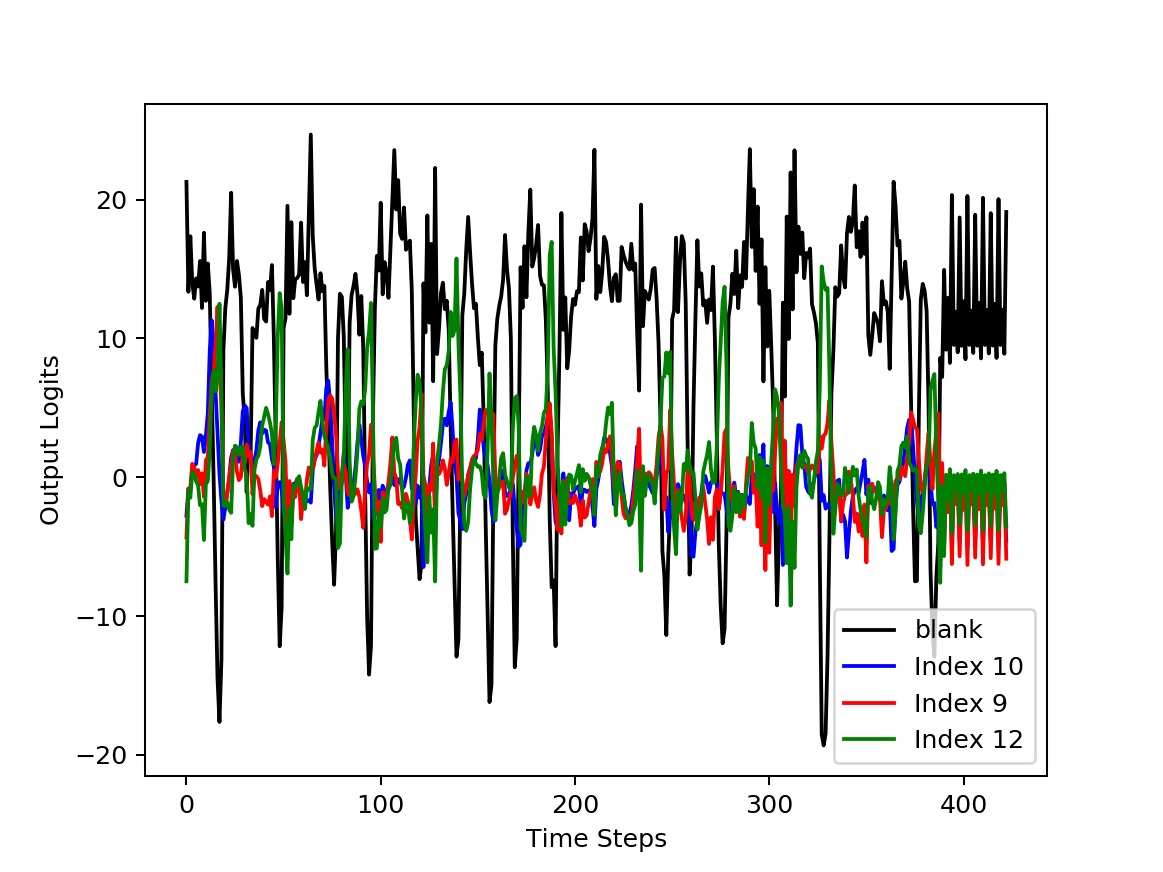

In [13]:
%matplotlib notebook
plt.plot(logits_out[:,0,27],'k-',label='blank')
plt.plot(logits_out[:,0,10],'b-',label='Index 10')
plt.plot(logits_out[:,0,9],'r-',label='Index 9')
plt.plot(logits_out[:,0,12],'g-',label='Index 12')
plt.legend(loc=4)
plt.xlabel('Time Steps')
plt.ylabel('Output Logits')

More about the spykes that tend to apear at the RNN output when using CTC 

[Supervised Sequence Labelling](https://www.cs.toronto.edu/~graves/preprint.pdf)